In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from commando import ComManDo
from commando.evaluation import generate_figure, test_partial
import matplotlib.pyplot as plt
from mmd_wrapper import mmd_combine
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing

2022-03-31 16:58:37.151590: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-31 16:58:37.151623: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
data1 = pd.read_csv("../data/scMNC/mouse_visual_cortex/data/geneExp_NMA.csv")
data2 = pd.read_csv("../data/scMNC/mouse_visual_cortex/data/efeature_NMA.csv")
type1 = np.array(data1['ttype'])
type2 = np.array(data2['ttype'])
data1 = np.array(data1)
data2 = np.array(data2)
data1 = data1[:, 1:21]
data2 = data2[:, 1:21]

# Sampling
idx = np.random.choice(range(data1.shape[0]), 500, replace=False)
data1, data2, type1, type2 = (x[idx] for x in (data1, data2, type1, type2))

# Labels
labels = [type1,type2]

# Preprocessing
data1 = preprocessing.scale(data1, axis=0)
data2 = preprocessing.scale(data2, axis=0)
dataset = [data1, data2]

# Utility
positivize = lambda X: [(1 + preprocessing.scale(1 + x)) / 2 for x in X]

In [4]:
# Reduced Priors
full_priors = np.eye(len(dataset[0]))

random_idx = np.random.choice(range(len(dataset[0])), int(.5 * len(dataset[0])), replace=False)
priors = np.zeros(len(dataset[0]))
priors[random_idx] = 1
half_priors = np.diag(priors)

none_priors = np.zeros((len(dataset[0]), len(dataset[0])))

In [5]:
# Vars
reduced_dim = 32

# ComManDo

In [6]:
cm = ComManDo(output_dim=reduced_dim, epoch_DNN=2000, log_DNN=500)
cm_data = cm.fit_transform(dataset=dataset)

use random seed: 666
Shape of Raw data
Dataset 0: (500, 20)
Dataset 1: (500, 20)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
epoch:[500/2000] err:0.2145 alpha:0.7883
epoch:[1000/2000] err:0.2501 alpha:0.9266
epoch:[1500/2000] err:0.2704 alpha:1.0158
epoch:[2000/2000] err:0.2803 alpha:1.0735
Finished Matching!
---------------------------------
Performing NLMA
epoch:[500/2000]: loss:1.157756
epoch:[1000/2000]: loss:0.971419
epoch:[1500/2000]: loss:0.961379
epoch:[2000/2000]: loss:0.957297
Finished Mapping!
Setup: 0.0025070689989661332
Get subset samples: 0.0016443858612885378
Run model: 0.0012173911259131273
Reconstruction loss: 5.650618568688515e-05
Difference calculation: 0.0005075492764070077
Aligned loss: 4.054260737830191e-05
F-cross loss: 1.355153139520553e-05
F-inv-cross loss: 1.4104848010174464e-05
Step: 0.0027675484409664932
Output: 0.007463944999472005
Total: 0.01623259387548387
---------------------------------
ComManDo Don

In [7]:
cm_data_half = ComManDo(output_dim=reduced_dim, epoch_DNN=2000, log_DNN=500, P=half_priors).fit_transform(dataset=dataset)
cm_data_none = ComManDo(output_dim=reduced_dim, epoch_DNN=2000, log_DNN=500, P=none_priors).fit_transform(dataset=dataset)

use random seed: 666
Shape of Raw data
Dataset 0: (500, 20)
Dataset 1: (500, 20)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
epoch:[500/2000] err:0.2145 alpha:0.7883
epoch:[1000/2000] err:0.2501 alpha:0.9266
epoch:[1500/2000] err:0.2704 alpha:1.0158
epoch:[2000/2000] err:0.2803 alpha:1.0735
Finished Matching!
---------------------------------
Performing NLMA
epoch:[500/2000]: loss:1.167728
epoch:[1000/2000]: loss:0.979826
epoch:[1500/2000]: loss:0.966903
epoch:[2000/2000]: loss:0.968695
Finished Mapping!
Setup: 0.002617605001432821
Get subset samples: 0.0017061051811266225
Run model: 0.0012362040183124918
Reconstruction loss: 5.715906690093106e-05
Difference calculation: 0.0005259462023153901
Aligned loss: 4.116012019148911e-05
F-cross loss: 1.3663475387147627e-05
F-inv-cross loss: 1.4171512005850673e-05
Step: 0.002779492943007426
Output: 0.0019095710013061762
Total: 0.010901078521986346
---------------------------------
ComManDo Do

In [8]:
# from sklearn.metrics import silhouette_score
# print([silhouette_score(cm_data[i], type1) for i in range(2)])

# UnionCom

In [9]:
uc = ComManDo(project_mode='tsne', output_dim=reduced_dim)
uc_data = uc.fit_transform(dataset=positivize(dataset))

use random seed: 666
Shape of Raw data
Dataset 0: (500, 20)
Dataset 1: (500, 20)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
epoch:[500/2000] err:0.2145 alpha:0.7883
epoch:[1000/2000] err:0.2501 alpha:0.9266
epoch:[1500/2000] err:0.2704 alpha:1.0158
epoch:[2000/2000] err:0.2803 alpha:1.0735
Finished Matching!
---------------------------------
Begin finding the embedded space
epoch:[10/100]: loss:2.344555, align_loss:0.400715
epoch:[20/100]: loss:2.223089, align_loss:0.424183
epoch:[30/100]: loss:2.105652, align_loss:0.425043
epoch:[40/100]: loss:1.890787, align_loss:0.431482
epoch:[50/100]: loss:1.980400, align_loss:0.416393
epoch:[60/100]: loss:2.165101, align_loss:0.426963
epoch:[70/100]: loss:2.035780, align_loss:0.418343
epoch:[80/100]: loss:2.009629, align_loss:0.420878
epoch:[90/100]: loss:2.099980, align_loss:0.409366
epoch:[100/100]: loss:2.205343, align_loss:0.409306
Done
---------------------------------
ComManDo Done!
Dis

# Nonlinear Manifold Alignment

In [13]:
nlma_data, _ = mmd_combine(data1, data2, method='maninetcluster', alignment='nonlinear manifold aln', num_dims=reduced_dim)

In [11]:
nlma_data_half, _ = mmd_combine(*dataset, method='maninetcluster', alignment='nonlinear manifold aln', num_dims=reduced_dim, corr=half_priors)

# Figure Generation

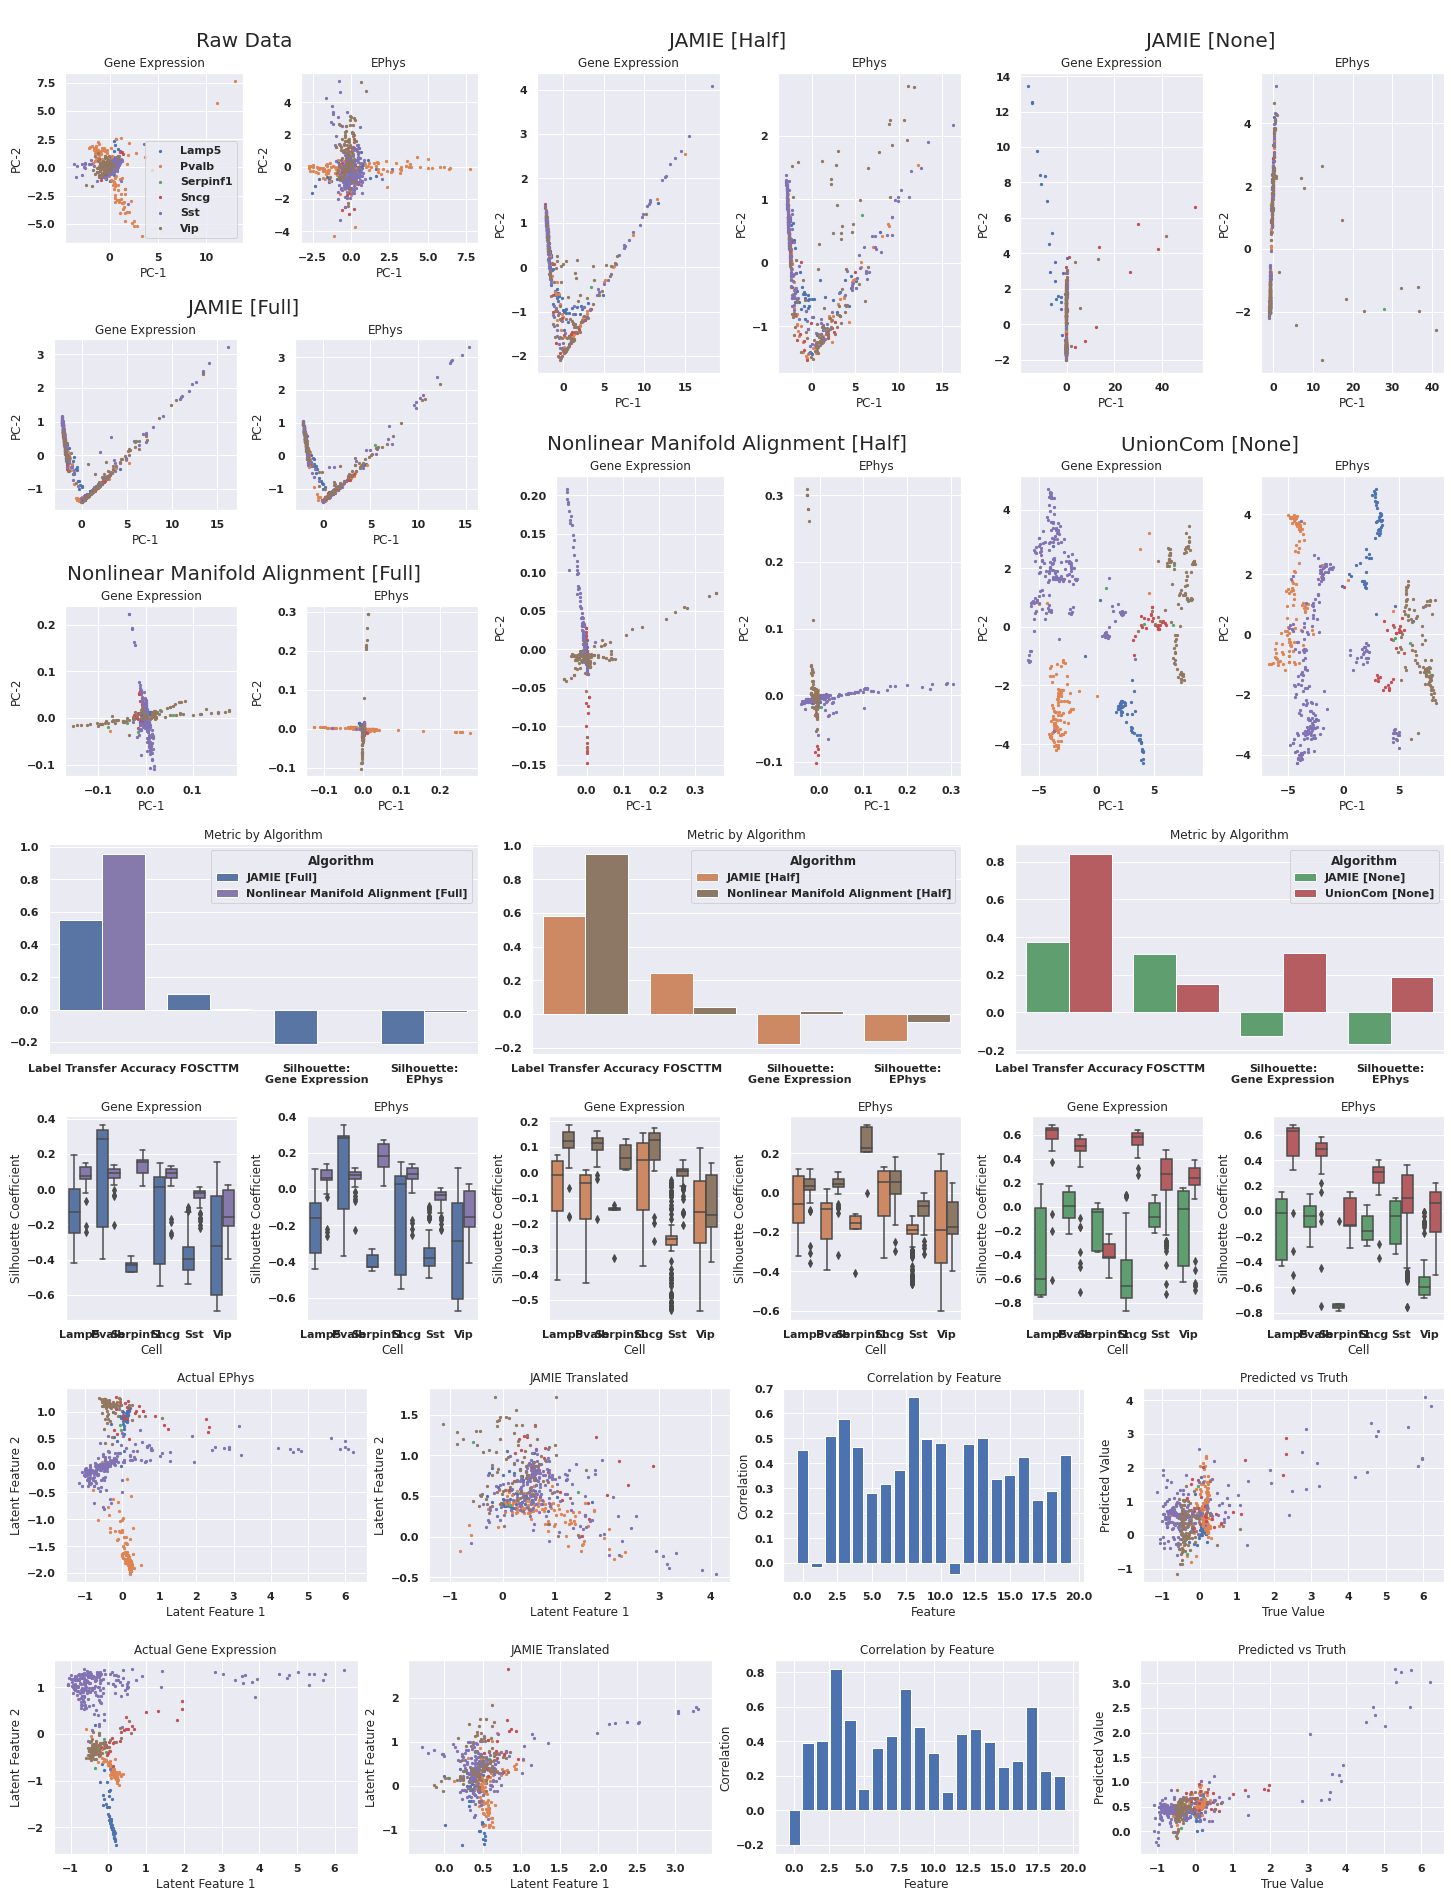

In [15]:
#%%capture --no-display
params = {
    'dataset_names': ['Gene Expression', 'EPhys'],
    'integrated_data': [cm_data, cm_data_half, cm_data_none, uc_data, nlma_data, nlma_data_half],
    'integrated_alg_names': ['JAMIE [Full]', 'JAMIE [Half]', 'JAMIE [None]', 'UnionCom [None]', 'Nonlinear Manifold Alignment [Full]', 'Nonlinear Manifold Alignment [Half]'],
    'alg_groups': [0, 1, 2, 2, 0, 1],
    'raw_data_group': 0,
    'integrated_rows': 1,
    'scale': 20,
    'reconstruction_features': {(0, 1): [3, 0], (1, 0): [3, 1]},
    'integrated_use_pca': True,
    'skip_partial': True,
    'skip_nn': True,
    'skip_simple': True,
}
generate_figure(cm, dataset, labels, **params)